# 1. Load index

In [1]:
import genomics_data_index

print(genomics_data_index.__version__)

0.6.0.dev2


In [2]:
import genomics_data_index.api as gdi

db = gdi.GenomicsDataIndex.connect('cases/case-full-si/index')
db

<GenomicsDataIndex(samples=85)>

# 2. Load metadata

In [3]:
import pandas as pd

metadata_df = pd.read_csv('metadata.tsv', sep='\t')
metadata_df['cluster'] = metadata_df['outbreak']
metadata_df.loc[metadata_df['cluster'] == 'outgroup', 'cluster'] = pd.NA

metadata_df.loc[metadata_df['dataSetName'] == '0810PADBR-1', 'Outgroup'] = '2014D-0070'
metadata_df.loc[metadata_df['dataSetName'] == '1405WAEXK-1', 'Outgroup'] = '2014C-3907'
metadata_df.loc[metadata_df['dataSetName'] == '1408MLGX6-3WGS', 'Outgroup'] = 'PNUSAL000730'
metadata_df.loc[metadata_df['dataSetName'] == '1203NYJAP-1 - Tuna Scrape Outbreak', 'Outgroup'] = 'CFSAN000212'

metadata_df

,dataSetName,strain,outbreak,SRArun_acc,reference,Organism,cluster,Outgroup
0,0810PADBR-1,D7321,0810PADBR-1,SRR3215135,GCA_001879185.2_ASM187918v2_genomic,Campylobacter jejuni,0810PADBR-1,2014D-0070
1,0810PADBR-1,D7320,0810PADBR-1,SRR3216186,GCA_001879185.2_ASM187918v2_genomic,Campylobacter jejuni,0810PADBR-1,2014D-0070
2,0810PADBR-1,2014D-0067,outgroup_0810PADBR-1,SRR1993270,GCA_001879185.2_ASM187918v2_genomic,Campylobacter jejuni,outgroup_0810PADBR-1,2014D-0070
3,0810PADBR-1,PNUSA000194,outgroup_0810PADBR-1,SRR2985019,GCA_001879185.2_ASM187918v2_genomic,Campylobacter jejuni,outgroup_0810PADBR-1,2014D-0070
4,0810PADBR-1,D5663,outgroup_0810PADBR-1,SRR1999649,GCA_001879185.2_ASM187918v2_genomic,Campylobacter jejuni,outgroup_0810PADBR-1,2014D-0070
...,...,...,...,...,...,...,...,...
80,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN000661,1203NYJAP-1,SRR498397,GCF_000439415.1_ASM43941v1_genomic,Salmonella enterica,1203NYJAP-1,CFSAN000212
81,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN000700,1203NYJAP-1,SRR498402,GCF_000439415.1_ASM43941v1_genomic,Salmonella enterica,1203NYJAP-1,CFSAN000212
82,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001112,1203NYJAP-1,SRR1258439,GCF_000439415.1_ASM43941v1_genomic,Salmonella enterica,1203NYJAP-1,CFSAN000212
83,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN000753,1203NYJAP-1,SRR498404,GCF_000439415.1_ASM43941v1_genomic,Salmonella enterica,1203NYJAP-1,CFSAN000212


# 3. Kmer tree

In [4]:
q = db.samples_query().join(metadata_df, sample_names_column='strain')
q

<DataFrameSamplesQuery[selected=100% (85/85) samples, unknown=0% (0/85) samples]>

In [5]:
import numpy as np
import time
from genomics_data_index.api.query.SamplesQuery import SamplesQuery

def build_time_kmer_tree(q: SamplesQuery, kmer_size: int, iterations: int):
    qtree = None
    tree_times = []
    for i in range(iterations):
        start = time.time()
        qtree = q.build_tree(kind='kmer', kmer_size=kmer_size)
        end = time.time()
        tree_times.append(end - start)
    
    return qtree, tree_times

kmer_size = 71

qkmer, tree_times = build_time_kmer_tree(q=q, kmer_size=kmer_size, iterations=3)
mean_time = np.mean(tree_times)
stddev_time = np.std(tree_times)
print(f'Took {mean_time} +- {stddev_time} seconds to build a kmer (k={kmer_size}) tree for {len(qkmer)} samples')
qkmer

Took 12.2737189133962 +- 0.1283974858101073 seconds to build a kmer (k=71) tree for 85 samples


<KmerTreeSamplesQuery[selected=100% (85/85) samples, unknown=0% (0/85) samples]>

In [6]:
q_campy = qkmer.isa('Campylobacter jejuni', isa_column='Organism', kind='dataframe')
q_ecoli = qkmer.isa('Escherichia coli', isa_column='Organism', kind='dataframe')
q_listeria = qkmer.isa('Listeria monocytogenes', isa_column='Organism', kind='dataframe')
q_salmonella = qkmer.isa('Salmonella enterica', isa_column='Organism', kind='dataframe')

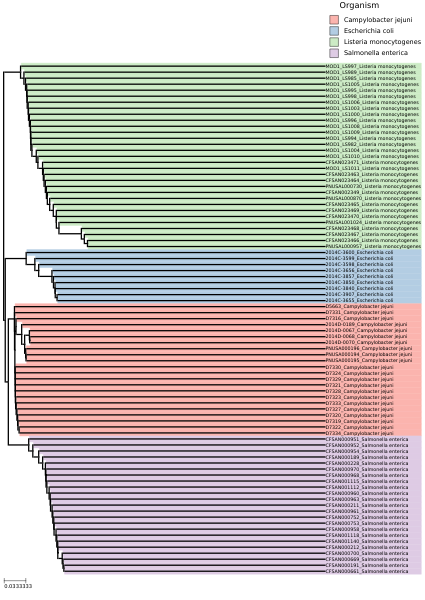

In [7]:
ts_kmer = qkmer.tree_styler(mode='r', tree_line_width=3, leaf_name_fontsize=8,
                  include_unknown=False, show_legend_type_labels=False,
                 legend_title='Organism',
                 show_border=False,
                 leaf_name_func=lambda n, m: f'{n}_{m["Organism"]}',
                 tree_scale=1500)\
 .highlight(q_campy, legend_label='Campylobacter jejuni')\
 .highlight(q_ecoli, legend_label='Escherichia coli')\
 .highlight(q_listeria, legend_label='Listeria monocytogenes')\
 .highlight(q_salmonella, legend_label='Salmonella enterica')

ts_kmer.render(h=600, ladderize=True)

In [8]:
x = ts_kmer.render('figures/tree-full-kmer.pdf', h=600, ladderize=True)

In [9]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

min_samples_cluster = 2

scorer = ClusterScorer(qkmer)
scores_organism = scorer.score_groupby(groupby_column='dataSetName', min_samples_count=min_samples_cluster)
scores_organism

,Score,Sample Count
dataSetName,,
0810PADBR-1,1.0,22
1203NYJAP-1 - Tuna Scrape Outbreak,1.0,23
1405WAEXK-1,1.0,9
1408MLGX6-3WGS,1.0,31


In [10]:
scores_outbreak = scorer.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
scores_outbreak

,Score,Sample Count
cluster,,
0810PADBR-1,0.666667,14
1203NYJAP-1,0.782609,18
1405WAEXK-1,0.333333,3
1408MLGX6-3WGS,0.903226,28
outgroup_0810PADBR-1,0.363636,8
outgroup_1203NYJAP-1 - Tuna Scrape Outbreak,0.250000,5
outgroup_1405WAEXK-1,1.000000,6
outgroup_1408MLGX6-3WGS,0.272727,3


# Tree comparison functions

1/32 leaves in the tree are not found in the query: [GCF_001047715.2_ASM104771v2_genomic]. Pruning tree to contain only those samples in the query (31/32).


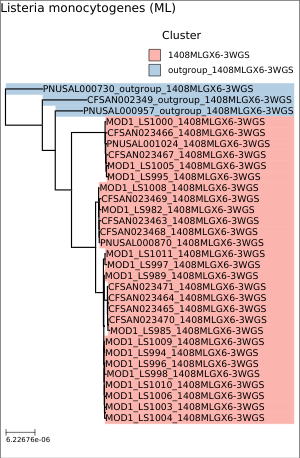

In [11]:
from typing import Dict, Any

from genomics_data_index.api.query.SamplesQuery import SamplesQuery
from genomics_data_index.api.viewer.TreeStyler import TreeStyler

def cluster_tree_query(organism_name: str, kmer_tree_query: SamplesQuery = None) -> SamplesQuery:
    reference_list = metadata_df[metadata_df['Organism'] == organism_name]['reference'].value_counts().index.tolist()
    if len(reference_list) != 1:
        raise Exception(f'Incorrect number of references for {organism_name}: {reference_list}')
    reference_name = reference_list[0]
    
    outgroup = metadata_df[metadata_df['Organism'] == organism_name]['Outgroup'].value_counts().index.tolist()[0]
    
    if kmer_tree_query is None:
        # I need to get tree and join so that I can exclude the reference genome from the tree
        ref_tree = db.reference_tree(reference_name)
        ref_length = db.connection.reference_service.find_reference_genome(reference_name).length
        t = db.samples_query().join_tree(ref_tree, kind='mutation', alignment_length=ref_length)    
        t = t.join(metadata_df, sample_names_column='strain')
    else:
        ref_samples = db.connection.sample_service.get_samples_set_associated_with_reference(reference_name)
        t = (kmer_tree_query.isin(ref_samples)).prune()
        
    t = t.set_outgroup(outgroup)
    return t

def cluster_tree_styler(tree_query: SamplesQuery, organism_name: str, is_kmer: bool = False) -> TreeStyler:
    cluster_names = metadata_df[metadata_df['Organism'] == organism_name]['cluster'].value_counts().index.tolist()
    cluster_names.sort()
        
    if is_kmer:
        title = f'{organism_name} (Kmer)\n'
    else:
        title = f'{organism_name} (ML)\n'
        
    ts = tree_query.tree_styler(tree_line_width=2, leaf_name_func=lambda n,m: f'{n}_{m["cluster"]}',
                       include_unknown=False, show_legend_type_labels=False,
                       legend_title='Cluster',
                       title=title,
                       figure_margin=10)
    
    for cluster in cluster_names:
        ts = ts.highlight(tree_query.isa(cluster, isa_column='cluster', kind='dataframe'), legend_label=cluster)
    
    return ts

def cluster_and_scores(organism_name: str) -> Dict[str, Any]:
    data = {}
    
    data['ml_query'] = cluster_tree_query(organism_name)
    data['ml_styler'] = cluster_tree_styler(data['ml_query'], organism_name)
    scorer_ml = ClusterScorer(data['ml_query'])
    data['ml_scores'] = scorer_ml.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
    
    data['kmer_query'] = cluster_tree_query(organism_name, kmer_tree_query=qkmer)
    data['kmer_styler'] = cluster_tree_styler(data['kmer_query'], organism_name, is_kmer=True)
    scorer_kmer = ClusterScorer(data['kmer_query'])
    data['kmer_scores'] = scorer_kmer.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
    
    data['ml_scores'] = data['ml_scores'].reset_index()
    data['ml_scores']['Organism'] = organism_name
    data['ml_scores']['Kind'] = 'ML'
    data['ml_scores'] = data['ml_scores'][['Organism', 'cluster', 'Kind', 'Score', 'Sample Count']]
    
    data['kmer_scores'] = data['kmer_scores'].reset_index()
    data['kmer_scores']['Organism'] = organism_name
    data['kmer_scores']['Kind'] = 'Kmer'
    data['kmer_scores'] = data['kmer_scores'][['Organism', 'cluster', 'Kind', 'Score', 'Sample Count']]
    
    data['scores'] = pd.concat([data['ml_scores'], data['kmer_scores']])
    
    return data
    
data = cluster_and_scores('Listeria monocytogenes')
data['ml_styler'].render(w=300, ladderize=True)

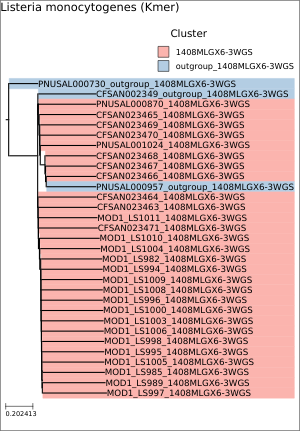

In [12]:
data['kmer_styler'].render(w=300, ladderize=True)

In [13]:
data['scores']

,Organism,cluster,Kind,Score,Sample Count
0,Listeria monocytogenes,1408MLGX6-3WGS,ML,1.000000,28
1,Listeria monocytogenes,outgroup_1408MLGX6-3WGS,ML,0.096774,3
0,Listeria monocytogenes,1408MLGX6-3WGS,Kmer,0.933333,28
1,Listeria monocytogenes,outgroup_1408MLGX6-3WGS,Kmer,0.096774,3


# Compare all organisms

In [14]:
organisms = metadata_df['Organism'].value_counts().index.tolist()
organisms

['Listeria monocytogenes',
 'Salmonella enterica',
 'Campylobacter jejuni',
 'Escherichia coli']

In [15]:
from pathlib import Path
import os

score_data = []

figures_dir = Path('figures')
if not figures_dir.exists():
    os.mkdir(figures_dir)

for organism in organisms:
    organism_data = cluster_and_scores(organism)
    score_data.append(organism_data['scores'])
    
    file_prefix = f'tree-{organism}'
    
    organism_data['kmer_styler'].render(str(figures_dir / f'{file_prefix}-kmer.pdf'), w=300, ladderize=True)
    organism_data['ml_styler'].render(str(figures_dir / f'{file_prefix}-ml.pdf'), w=300, ladderize=True)
    
scores_df = pd.concat(score_data)
scores_df

1/32 leaves in the tree are not found in the query: [GCF_001047715.2_ASM104771v2_genomic]. Pruning tree to contain only those samples in the query (31/32).
1/24 leaves in the tree are not found in the query: [GCF_000439415.1_ASM43941v1_genomic]. Pruning tree to contain only those samples in the query (23/24).
1/23 leaves in the tree are not found in the query: [GCA_001879185.2_ASM187918v2_genomic]. Pruning tree to contain only those samples in the query (22/23).
1/10 leaves in the tree are not found in the query: [GCF_000703365.1_Ec2011C-3609_genomic]. Pruning tree to contain only those samples in the query (9/10).


,Organism,cluster,Kind,Score,Sample Count
0,Listeria monocytogenes,1408MLGX6-3WGS,ML,1.000000,28
1,Listeria monocytogenes,outgroup_1408MLGX6-3WGS,ML,0.096774,3
0,Listeria monocytogenes,1408MLGX6-3WGS,Kmer,0.933333,28
1,Listeria monocytogenes,outgroup_1408MLGX6-3WGS,Kmer,0.096774,3
0,Salmonella enterica,1203NYJAP-1,ML,1.000000,18
1,Salmonella enterica,outgroup_1203NYJAP-1 - Tuna Scrape Outbreak,ML,0.217391,5
0,Salmonella enterica,1203NYJAP-1,Kmer,0.818182,18
1,Salmonella enterica,outgroup_1203NYJAP-1 - Tuna Scrape Outbreak,Kmer,0.217391,5
0,Campylobacter jejuni,0810PADBR-1,ML,1.000000,14
1,Campylobacter jejuni,outgroup_0810PADBR-1,ML,0.363636,8


In [16]:
monophyletic_df = scores_df[~scores_df['cluster'].str.contains('outgroup_')].copy()
monophyletic_df['Monophyletic'] = monophyletic_df['Score'] == 1
monophyletic_df

,Organism,cluster,Kind,Score,Sample Count,Monophyletic
0,Listeria monocytogenes,1408MLGX6-3WGS,ML,1.000000,28,True
0,Listeria monocytogenes,1408MLGX6-3WGS,Kmer,0.933333,28,False
0,Salmonella enterica,1203NYJAP-1,ML,1.000000,18,True
0,Salmonella enterica,1203NYJAP-1,Kmer,0.818182,18,False
0,Campylobacter jejuni,0810PADBR-1,ML,1.000000,14,True
0,Campylobacter jejuni,0810PADBR-1,Kmer,0.933333,14,False
0,Escherichia coli,1405WAEXK-1,ML,1.000000,3,True
0,Escherichia coli,1405WAEXK-1,Kmer,1.000000,3,True
